In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [24]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
#loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 1181.554504
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* \
$Loss = \frac{1}{N}\sum_{i}{-\log{\frac{e^{f_{y_i}}}{\sum_{j}{e^{f_j}}}}}$\
当所有$weight$初始化为接近0的随机数，所有$f_j$也接近0，$Loss=\frac{1}{N}\times N\times (-\log{\frac{1}{C}})=-\log{\frac{1}{C}}$\
本问题中$C=10$，故$Loss=-\log{\frac{1}{10}}=-\log{(0.1)}$

In [17]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.452098 analytic: 0.452098, relative error: 2.767663e-09
numerical: 0.641855 analytic: 0.641855, relative error: 5.968830e-08
numerical: 1.006181 analytic: 1.006181, relative error: 2.538211e-08
numerical: -2.471089 analytic: -2.471090, relative error: 3.804675e-08
numerical: 0.025595 analytic: 0.025595, relative error: 1.508205e-06
numerical: 0.396007 analytic: 0.396007, relative error: 5.941774e-08
numerical: -3.832726 analytic: -3.832726, relative error: 1.979837e-08
numerical: -0.117843 analytic: -0.117843, relative error: 2.554362e-07
numerical: -1.080350 analytic: -1.080350, relative error: 9.401523e-10
numerical: -3.162225 analytic: -3.162225, relative error: 6.057527e-09
numerical: 0.361973 analytic: 0.361973, relative error: 9.014120e-09
numerical: 0.849726 analytic: 0.849726, relative error: 9.541227e-09
numerical: 2.877891 analytic: 2.877890, relative error: 2.554808e-08
numerical: 1.190600 analytic: 1.190600, relative error: 1.860466e-08
numerical: 2.221200 anal

In [35]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.363109e+00 computed in 0.076255s
vectorized loss: 2.363109e+00 computed in 0.002733s
Loss difference: 0.000000
Gradient difference: 0.000000


In [36]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for log_rate in np.linspace(-7,-5,21):
    rate = 10 ** log_rate
    for r in np.linspace(2.5,5,26):
        reg = r * 10 ** 4
        softmax = Softmax()
        _ = softmax.train(X_train, y_train, learning_rate=rate, reg=reg,
                      num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        accu_train = np.mean(y_train == y_train_pred)
        accu_val = np.mean(y_val == y_val_pred)
        results[(rate,reg)] = (accu_train,accu_val)
        if best_val < accu_val:
            best_val = accu_val
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 773.932026
iteration 100 / 1500: loss 283.783429
iteration 200 / 1500: loss 105.039958
iteration 300 / 1500: loss 39.888722
iteration 400 / 1500: loss 15.824565
iteration 500 / 1500: loss 7.180106
iteration 600 / 1500: loss 3.954939
iteration 700 / 1500: loss 2.774810
iteration 800 / 1500: loss 2.260631
iteration 900 / 1500: loss 2.121691
iteration 1000 / 1500: loss 2.094425
iteration 1100 / 1500: loss 2.015820
iteration 1200 / 1500: loss 2.148465
iteration 1300 / 1500: loss 2.024036
iteration 1400 / 1500: loss 2.127012
iteration 0 / 1500: loss 802.359100
iteration 100 / 1500: loss 282.480565
iteration 200 / 1500: loss 100.477679
iteration 300 / 1500: loss 36.630263
iteration 400 / 1500: loss 14.269631
iteration 500 / 1500: loss 6.275264
iteration 600 / 1500: loss 3.532757
iteration 700 / 1500: loss 2.580896
iteration 800 / 1500: loss 2.236764
iteration 900 / 1500: loss 2.131744
iteration 1000 / 1500: loss 2.035678
iteration 1100 / 1500: loss 2.072605
iteration

iteration 1400 / 1500: loss 2.055202
iteration 0 / 1500: loss 1240.899381
iteration 100 / 1500: loss 249.497734
iteration 200 / 1500: loss 51.675873
iteration 300 / 1500: loss 12.085394
iteration 400 / 1500: loss 4.074098
iteration 500 / 1500: loss 2.489598
iteration 600 / 1500: loss 2.146255
iteration 700 / 1500: loss 2.144112
iteration 800 / 1500: loss 2.085700
iteration 900 / 1500: loss 2.096398
iteration 1000 / 1500: loss 2.120957
iteration 1100 / 1500: loss 2.085791
iteration 1200 / 1500: loss 2.051981
iteration 1300 / 1500: loss 2.099291
iteration 1400 / 1500: loss 2.110010
iteration 0 / 1500: loss 1240.111121
iteration 100 / 1500: loss 239.880707
iteration 200 / 1500: loss 47.686572
iteration 300 / 1500: loss 10.832025
iteration 400 / 1500: loss 3.827140
iteration 500 / 1500: loss 2.442492
iteration 600 / 1500: loss 2.202715
iteration 700 / 1500: loss 2.105927
iteration 800 / 1500: loss 2.071205
iteration 900 / 1500: loss 2.102193
iteration 1000 / 1500: loss 2.074636
iteration 1

iteration 1300 / 1500: loss 2.014096
iteration 1400 / 1500: loss 2.089498
iteration 0 / 1500: loss 893.737778
iteration 100 / 1500: loss 206.852836
iteration 200 / 1500: loss 49.172971
iteration 300 / 1500: loss 12.922490
iteration 400 / 1500: loss 4.566226
iteration 500 / 1500: loss 2.686772
iteration 600 / 1500: loss 2.234303
iteration 700 / 1500: loss 2.076304
iteration 800 / 1500: loss 2.035895
iteration 900 / 1500: loss 2.027217
iteration 1000 / 1500: loss 2.117586
iteration 1100 / 1500: loss 2.035314
iteration 1200 / 1500: loss 2.087116
iteration 1300 / 1500: loss 2.031253
iteration 1400 / 1500: loss 2.023349
iteration 0 / 1500: loss 932.440131
iteration 100 / 1500: loss 204.876107
iteration 200 / 1500: loss 46.441902
iteration 300 / 1500: loss 11.773448
iteration 400 / 1500: loss 4.213814
iteration 500 / 1500: loss 2.600481
iteration 600 / 1500: loss 2.129561
iteration 700 / 1500: loss 2.117670
iteration 800 / 1500: loss 2.111425
iteration 900 / 1500: loss 2.074266
iteration 100

iteration 1200 / 1500: loss 2.134863
iteration 1300 / 1500: loss 2.088724
iteration 1400 / 1500: loss 2.109484
iteration 0 / 1500: loss 1363.038472
iteration 100 / 1500: loss 147.989130
iteration 200 / 1500: loss 17.745202
iteration 300 / 1500: loss 3.759497
iteration 400 / 1500: loss 2.283184
iteration 500 / 1500: loss 2.101129
iteration 600 / 1500: loss 2.111804
iteration 700 / 1500: loss 2.118845
iteration 800 / 1500: loss 2.113233
iteration 900 / 1500: loss 2.112078
iteration 1000 / 1500: loss 2.133303
iteration 1100 / 1500: loss 2.095312
iteration 1200 / 1500: loss 2.186576
iteration 1300 / 1500: loss 2.102127
iteration 1400 / 1500: loss 2.087270
iteration 0 / 1500: loss 1385.057226
iteration 100 / 1500: loss 142.814575
iteration 200 / 1500: loss 16.404606
iteration 300 / 1500: loss 3.580574
iteration 400 / 1500: loss 2.188867
iteration 500 / 1500: loss 2.120570
iteration 600 / 1500: loss 2.135973
iteration 700 / 1500: loss 2.092017
iteration 800 / 1500: loss 2.124922
iteration 90

iteration 1200 / 1500: loss 2.061367
iteration 1300 / 1500: loss 2.118804
iteration 1400 / 1500: loss 2.072250
iteration 0 / 1500: loss 1034.143649
iteration 100 / 1500: loss 127.288453
iteration 200 / 1500: loss 17.294207
iteration 300 / 1500: loss 3.933909
iteration 400 / 1500: loss 2.303796
iteration 500 / 1500: loss 2.093344
iteration 600 / 1500: loss 2.095937
iteration 700 / 1500: loss 2.108245
iteration 800 / 1500: loss 2.083524
iteration 900 / 1500: loss 2.048358
iteration 1000 / 1500: loss 2.103784
iteration 1100 / 1500: loss 2.098484
iteration 1200 / 1500: loss 2.078239
iteration 1300 / 1500: loss 2.094063
iteration 1400 / 1500: loss 2.101782
iteration 0 / 1500: loss 1047.640049
iteration 100 / 1500: loss 120.849764
iteration 200 / 1500: loss 15.613026
iteration 300 / 1500: loss 3.563722
iteration 400 / 1500: loss 2.314993
iteration 500 / 1500: loss 2.096474
iteration 600 / 1500: loss 2.091694
iteration 700 / 1500: loss 2.110187
iteration 800 / 1500: loss 2.062782
iteration 90

iteration 1200 / 1500: loss 2.113918
iteration 1300 / 1500: loss 2.097751
iteration 1400 / 1500: loss 2.099707
iteration 0 / 1500: loss 1473.054461
iteration 100 / 1500: loss 70.196693
iteration 200 / 1500: loss 5.278413
iteration 300 / 1500: loss 2.275905
iteration 400 / 1500: loss 2.055986
iteration 500 / 1500: loss 2.110094
iteration 600 / 1500: loss 2.122658
iteration 700 / 1500: loss 2.115814
iteration 800 / 1500: loss 2.091694
iteration 900 / 1500: loss 2.187651
iteration 1000 / 1500: loss 2.093402
iteration 1100 / 1500: loss 2.108998
iteration 1200 / 1500: loss 2.106809
iteration 1300 / 1500: loss 2.158533
iteration 1400 / 1500: loss 2.091120
iteration 0 / 1500: loss 1480.342027
iteration 100 / 1500: loss 66.442707
iteration 200 / 1500: loss 4.856823
iteration 300 / 1500: loss 2.255604
iteration 400 / 1500: loss 2.169463
iteration 500 / 1500: loss 2.113872
iteration 600 / 1500: loss 2.128601
iteration 700 / 1500: loss 2.101393
iteration 800 / 1500: loss 2.126263
iteration 900 / 

iteration 1200 / 1500: loss 2.143410
iteration 1300 / 1500: loss 2.142757
iteration 1400 / 1500: loss 2.117336
iteration 0 / 1500: loss 1138.844384
iteration 100 / 1500: loss 59.713241
iteration 200 / 1500: loss 4.987963
iteration 300 / 1500: loss 2.300650
iteration 400 / 1500: loss 2.031546
iteration 500 / 1500: loss 2.046091
iteration 600 / 1500: loss 2.107737
iteration 700 / 1500: loss 2.074255
iteration 800 / 1500: loss 2.090344
iteration 900 / 1500: loss 2.117522
iteration 1000 / 1500: loss 2.047903
iteration 1100 / 1500: loss 2.047610
iteration 1200 / 1500: loss 2.145318
iteration 1300 / 1500: loss 2.116537
iteration 1400 / 1500: loss 2.060647
iteration 0 / 1500: loss 1168.891532
iteration 100 / 1500: loss 56.688434
iteration 200 / 1500: loss 4.649164
iteration 300 / 1500: loss 2.257439
iteration 400 / 1500: loss 2.094756
iteration 500 / 1500: loss 2.119132
iteration 600 / 1500: loss 2.113996
iteration 700 / 1500: loss 2.104826
iteration 800 / 1500: loss 2.087083
iteration 900 / 

iteration 1200 / 1500: loss 2.036578
iteration 1300 / 1500: loss 2.036731
iteration 1400 / 1500: loss 2.151133
iteration 0 / 1500: loss 805.903054
iteration 100 / 1500: loss 59.468471
iteration 200 / 1500: loss 6.191677
iteration 300 / 1500: loss 2.386118
iteration 400 / 1500: loss 2.096513
iteration 500 / 1500: loss 2.089794
iteration 600 / 1500: loss 2.109536
iteration 700 / 1500: loss 2.068816
iteration 800 / 1500: loss 2.089666
iteration 900 / 1500: loss 2.131082
iteration 1000 / 1500: loss 2.034620
iteration 1100 / 1500: loss 2.064547
iteration 1200 / 1500: loss 2.079916
iteration 1300 / 1500: loss 2.031521
iteration 1400 / 1500: loss 2.010606
iteration 0 / 1500: loss 822.739895
iteration 100 / 1500: loss 55.086596
iteration 200 / 1500: loss 5.484954
iteration 300 / 1500: loss 2.281119
iteration 400 / 1500: loss 2.053783
iteration 500 / 1500: loss 2.087239
iteration 600 / 1500: loss 2.024291
iteration 700 / 1500: loss 2.016821
iteration 800 / 1500: loss 2.060021
iteration 900 / 15

iteration 1200 / 1500: loss 2.065163
iteration 1300 / 1500: loss 2.120802
iteration 1400 / 1500: loss 2.111242
iteration 0 / 1500: loss 1269.926567
iteration 100 / 1500: loss 21.712069
iteration 200 / 1500: loss 2.371778
iteration 300 / 1500: loss 2.136528
iteration 400 / 1500: loss 2.077904
iteration 500 / 1500: loss 2.146452
iteration 600 / 1500: loss 2.119676
iteration 700 / 1500: loss 2.076128
iteration 800 / 1500: loss 2.116601
iteration 900 / 1500: loss 2.075926
iteration 1000 / 1500: loss 2.141441
iteration 1100 / 1500: loss 2.081298
iteration 1200 / 1500: loss 2.107845
iteration 1300 / 1500: loss 2.098203
iteration 1400 / 1500: loss 2.146820
iteration 0 / 1500: loss 1311.092849
iteration 100 / 1500: loss 20.356823
iteration 200 / 1500: loss 2.377660
iteration 300 / 1500: loss 2.069841
iteration 400 / 1500: loss 2.079651
iteration 500 / 1500: loss 2.114103
iteration 600 / 1500: loss 2.064829
iteration 700 / 1500: loss 2.117375
iteration 800 / 1500: loss 2.069793
iteration 900 / 

iteration 1200 / 1500: loss 2.060010
iteration 1300 / 1500: loss 2.108879
iteration 1400 / 1500: loss 2.094943
iteration 0 / 1500: loss 935.642213
iteration 100 / 1500: loss 22.069621
iteration 200 / 1500: loss 2.515589
iteration 300 / 1500: loss 2.079520
iteration 400 / 1500: loss 2.056485
iteration 500 / 1500: loss 2.075432
iteration 600 / 1500: loss 2.115445
iteration 700 / 1500: loss 2.069826
iteration 800 / 1500: loss 2.070362
iteration 900 / 1500: loss 2.094803
iteration 1000 / 1500: loss 2.164627
iteration 1100 / 1500: loss 2.079404
iteration 1200 / 1500: loss 2.093250
iteration 1300 / 1500: loss 2.038665
iteration 1400 / 1500: loss 2.010446
iteration 0 / 1500: loss 963.723385
iteration 100 / 1500: loss 20.283423
iteration 200 / 1500: loss 2.403081
iteration 300 / 1500: loss 2.022199
iteration 400 / 1500: loss 2.091684
iteration 500 / 1500: loss 2.061156
iteration 600 / 1500: loss 2.014244
iteration 700 / 1500: loss 2.096999
iteration 800 / 1500: loss 2.082036
iteration 900 / 15

iteration 1200 / 1500: loss 2.079050
iteration 1300 / 1500: loss 2.104826
iteration 1400 / 1500: loss 2.089769
iteration 0 / 1500: loss 1371.060935
iteration 100 / 1500: loss 6.315298
iteration 200 / 1500: loss 2.129799
iteration 300 / 1500: loss 2.110657
iteration 400 / 1500: loss 2.122975
iteration 500 / 1500: loss 2.110365
iteration 600 / 1500: loss 2.107098
iteration 700 / 1500: loss 2.146224
iteration 800 / 1500: loss 2.124377
iteration 900 / 1500: loss 2.052627
iteration 1000 / 1500: loss 2.159308
iteration 1100 / 1500: loss 2.081901
iteration 1200 / 1500: loss 2.078832
iteration 1300 / 1500: loss 2.081757
iteration 1400 / 1500: loss 2.096392
iteration 0 / 1500: loss 1443.349919
iteration 100 / 1500: loss 5.938900
iteration 200 / 1500: loss 2.169588
iteration 300 / 1500: loss 2.162665
iteration 400 / 1500: loss 2.128862
iteration 500 / 1500: loss 2.136690
iteration 600 / 1500: loss 2.135867
iteration 700 / 1500: loss 2.089406
iteration 800 / 1500: loss 2.102790
iteration 900 / 15

iteration 1300 / 1500: loss 2.104992
iteration 1400 / 1500: loss 2.086084
iteration 0 / 1500: loss 1062.474604
iteration 100 / 1500: loss 6.420374
iteration 200 / 1500: loss 2.153842
iteration 300 / 1500: loss 2.042899
iteration 400 / 1500: loss 2.128570
iteration 500 / 1500: loss 2.089753
iteration 600 / 1500: loss 2.089758
iteration 700 / 1500: loss 2.091101
iteration 800 / 1500: loss 2.069597
iteration 900 / 1500: loss 2.057065
iteration 1000 / 1500: loss 2.135297
iteration 1100 / 1500: loss 2.075580
iteration 1200 / 1500: loss 2.100025
iteration 1300 / 1500: loss 2.108500
iteration 1400 / 1500: loss 2.128042
iteration 0 / 1500: loss 1080.197085
iteration 100 / 1500: loss 5.813871
iteration 200 / 1500: loss 2.149266
iteration 300 / 1500: loss 2.082760
iteration 400 / 1500: loss 2.108168
iteration 500 / 1500: loss 2.118291
iteration 600 / 1500: loss 2.087793
iteration 700 / 1500: loss 2.070856
iteration 800 / 1500: loss 2.103092
iteration 900 / 1500: loss 2.135463
iteration 1000 / 15

iteration 1400 / 1500: loss 2.053488
iteration 0 / 1500: loss 1514.869463
iteration 100 / 1500: loss 2.644041
iteration 200 / 1500: loss 2.143572
iteration 300 / 1500: loss 2.082998
iteration 400 / 1500: loss 2.132505
iteration 500 / 1500: loss 2.130655
iteration 600 / 1500: loss 2.143998
iteration 700 / 1500: loss 2.113641
iteration 800 / 1500: loss 2.077664
iteration 900 / 1500: loss 2.115387
iteration 1000 / 1500: loss 2.145100
iteration 1100 / 1500: loss 2.153052
iteration 1200 / 1500: loss 2.107081
iteration 1300 / 1500: loss 2.104079
iteration 1400 / 1500: loss 2.152787
iteration 0 / 1500: loss 1525.971318
iteration 100 / 1500: loss 2.558530
iteration 200 / 1500: loss 2.124518
iteration 300 / 1500: loss 2.109562
iteration 400 / 1500: loss 2.038855
iteration 500 / 1500: loss 2.202164
iteration 600 / 1500: loss 2.091588
iteration 700 / 1500: loss 2.099551
iteration 800 / 1500: loss 2.137078
iteration 900 / 1500: loss 2.165801
iteration 1000 / 1500: loss 2.090030
iteration 1100 / 15

iteration 0 / 1500: loss 1164.455292
iteration 100 / 1500: loss 2.586347
iteration 200 / 1500: loss 2.124645
iteration 300 / 1500: loss 2.119677
iteration 400 / 1500: loss 2.096994
iteration 500 / 1500: loss 2.073655
iteration 600 / 1500: loss 2.078814
iteration 700 / 1500: loss 2.103132
iteration 800 / 1500: loss 2.149204
iteration 900 / 1500: loss 2.065797
iteration 1000 / 1500: loss 2.085514
iteration 1100 / 1500: loss 2.121470
iteration 1200 / 1500: loss 2.062319
iteration 1300 / 1500: loss 2.027958
iteration 1400 / 1500: loss 2.103277
iteration 0 / 1500: loss 1188.856747
iteration 100 / 1500: loss 2.538798
iteration 200 / 1500: loss 2.034433
iteration 300 / 1500: loss 2.072804
iteration 400 / 1500: loss 2.069388
iteration 500 / 1500: loss 2.154742
iteration 600 / 1500: loss 2.107696
iteration 700 / 1500: loss 2.128052
iteration 800 / 1500: loss 2.123281
iteration 900 / 1500: loss 2.109288
iteration 1000 / 1500: loss 2.127830
iteration 1100 / 1500: loss 2.072291
iteration 1200 / 15

iteration 100 / 1500: loss 2.822584
iteration 200 / 1500: loss 2.107781
iteration 300 / 1500: loss 2.070606
iteration 400 / 1500: loss 2.047094
iteration 500 / 1500: loss 2.063703
iteration 600 / 1500: loss 2.075246
iteration 700 / 1500: loss 2.060188
iteration 800 / 1500: loss 2.041445
iteration 900 / 1500: loss 2.069579
iteration 1000 / 1500: loss 2.040740
iteration 1100 / 1500: loss 1.997599
iteration 1200 / 1500: loss 2.092979
iteration 1300 / 1500: loss 2.121568
iteration 1400 / 1500: loss 2.134590
iteration 0 / 1500: loss 863.561158
iteration 100 / 1500: loss 2.749297
iteration 200 / 1500: loss 2.032980
iteration 300 / 1500: loss 2.079801
iteration 400 / 1500: loss 2.070839
iteration 500 / 1500: loss 2.048609
iteration 600 / 1500: loss 2.067384
iteration 700 / 1500: loss 2.063683
iteration 800 / 1500: loss 2.108577
iteration 900 / 1500: loss 2.040509
iteration 1000 / 1500: loss 2.082957
iteration 1100 / 1500: loss 2.031563
iteration 1200 / 1500: loss 2.035442
iteration 1300 / 150

iteration 200 / 1500: loss 2.129089
iteration 300 / 1500: loss 2.169580
iteration 400 / 1500: loss 2.080425
iteration 500 / 1500: loss 2.113698
iteration 600 / 1500: loss 2.121296
iteration 700 / 1500: loss 2.098989
iteration 800 / 1500: loss 2.097949
iteration 900 / 1500: loss 2.083440
iteration 1000 / 1500: loss 2.081334
iteration 1100 / 1500: loss 2.048393
iteration 1200 / 1500: loss 2.075433
iteration 1300 / 1500: loss 2.082639
iteration 1400 / 1500: loss 2.118735
iteration 0 / 1500: loss 1342.603042
iteration 100 / 1500: loss 2.157176
iteration 200 / 1500: loss 2.062470
iteration 300 / 1500: loss 2.120785
iteration 400 / 1500: loss 2.138901
iteration 500 / 1500: loss 2.094963
iteration 600 / 1500: loss 2.130803
iteration 700 / 1500: loss 2.173212
iteration 800 / 1500: loss 2.090676
iteration 900 / 1500: loss 2.090619
iteration 1000 / 1500: loss 2.155966
iteration 1100 / 1500: loss 2.114272
iteration 1200 / 1500: loss 2.109125
iteration 1300 / 1500: loss 2.132586
iteration 1400 / 1

iteration 300 / 1500: loss 2.076280
iteration 400 / 1500: loss 2.113769
iteration 500 / 1500: loss 2.114534
iteration 600 / 1500: loss 2.117303
iteration 700 / 1500: loss 2.094395
iteration 800 / 1500: loss 2.128485
iteration 900 / 1500: loss 2.066443
iteration 1000 / 1500: loss 2.050036
iteration 1100 / 1500: loss 2.080525
iteration 1200 / 1500: loss 2.051317
iteration 1300 / 1500: loss 2.082067
iteration 1400 / 1500: loss 2.024756
iteration 0 / 1500: loss 978.695944
iteration 100 / 1500: loss 2.098553
iteration 200 / 1500: loss 2.090715
iteration 300 / 1500: loss 2.119644
iteration 400 / 1500: loss 2.107542
iteration 500 / 1500: loss 2.065764
iteration 600 / 1500: loss 2.070316
iteration 700 / 1500: loss 2.069194
iteration 800 / 1500: loss 2.094242
iteration 900 / 1500: loss 2.044448
iteration 1000 / 1500: loss 2.126590
iteration 1100 / 1500: loss 2.137957
iteration 1200 / 1500: loss 2.066479
iteration 1300 / 1500: loss 2.051874
iteration 1400 / 1500: loss 2.106924
iteration 0 / 1500

iteration 400 / 1500: loss 2.092170
iteration 500 / 1500: loss 2.115189
iteration 600 / 1500: loss 2.113705
iteration 700 / 1500: loss 2.136211
iteration 800 / 1500: loss 2.085116
iteration 900 / 1500: loss 2.077655
iteration 1000 / 1500: loss 2.165106
iteration 1100 / 1500: loss 2.131474
iteration 1200 / 1500: loss 2.104995
iteration 1300 / 1500: loss 2.157673
iteration 1400 / 1500: loss 2.122320
iteration 0 / 1500: loss 1459.606129
iteration 100 / 1500: loss 2.108651
iteration 200 / 1500: loss 2.156649
iteration 300 / 1500: loss 2.094623
iteration 400 / 1500: loss 2.203966
iteration 500 / 1500: loss 2.109797
iteration 600 / 1500: loss 2.136962
iteration 700 / 1500: loss 2.151149
iteration 800 / 1500: loss 2.120663
iteration 900 / 1500: loss 2.142199
iteration 1000 / 1500: loss 2.081744
iteration 1100 / 1500: loss 2.093298
iteration 1200 / 1500: loss 2.077679
iteration 1300 / 1500: loss 2.111537
iteration 1400 / 1500: loss 2.152694
iteration 0 / 1500: loss 1493.931651
iteration 100 / 

iteration 500 / 1500: loss 2.076836
iteration 600 / 1500: loss 2.102124
iteration 700 / 1500: loss 2.137757
iteration 800 / 1500: loss 2.066278
iteration 900 / 1500: loss 2.146115
iteration 1000 / 1500: loss 2.095233
iteration 1100 / 1500: loss 2.090098
iteration 1200 / 1500: loss 2.059613
iteration 1300 / 1500: loss 2.132248
iteration 1400 / 1500: loss 2.093829
iteration 0 / 1500: loss 1116.178067
iteration 100 / 1500: loss 2.168599
iteration 200 / 1500: loss 2.109952
iteration 300 / 1500: loss 2.132668
iteration 400 / 1500: loss 2.060647
iteration 500 / 1500: loss 2.117182
iteration 600 / 1500: loss 2.093932
iteration 700 / 1500: loss 2.083627
iteration 800 / 1500: loss 2.069742
iteration 900 / 1500: loss 2.092045
iteration 1000 / 1500: loss 2.121687
iteration 1100 / 1500: loss 2.102334
iteration 1200 / 1500: loss 2.085053
iteration 1300 / 1500: loss 2.099085
iteration 1400 / 1500: loss 2.112008
iteration 0 / 1500: loss 1136.853918
iteration 100 / 1500: loss 2.167407
iteration 200 / 

iteration 600 / 1500: loss 2.094808
iteration 700 / 1500: loss 2.105898
iteration 800 / 1500: loss 2.090692
iteration 900 / 1500: loss 2.108972
iteration 1000 / 1500: loss 2.144097
iteration 1100 / 1500: loss 2.160369
iteration 1200 / 1500: loss 2.127268
iteration 1300 / 1500: loss 2.179392
iteration 1400 / 1500: loss 2.130556
iteration 0 / 1500: loss 779.486778
iteration 100 / 1500: loss 2.084523
iteration 200 / 1500: loss 2.093780
iteration 300 / 1500: loss 2.037772
iteration 400 / 1500: loss 2.017268
iteration 500 / 1500: loss 2.074439
iteration 600 / 1500: loss 2.064946
iteration 700 / 1500: loss 2.043904
iteration 800 / 1500: loss 2.031662
iteration 900 / 1500: loss 2.078649
iteration 1000 / 1500: loss 2.067106
iteration 1100 / 1500: loss 1.993262
iteration 1200 / 1500: loss 2.028587
iteration 1300 / 1500: loss 2.064994
iteration 1400 / 1500: loss 2.042780
iteration 0 / 1500: loss 801.702975
iteration 100 / 1500: loss 2.042228
iteration 200 / 1500: loss 2.066406
iteration 300 / 15

iteration 700 / 1500: loss 2.107375
iteration 800 / 1500: loss 2.151632
iteration 900 / 1500: loss 2.138572
iteration 1000 / 1500: loss 2.125206
iteration 1100 / 1500: loss 2.061047
iteration 1200 / 1500: loss 2.145163
iteration 1300 / 1500: loss 2.072191
iteration 1400 / 1500: loss 2.091669
iteration 0 / 1500: loss 1221.637935
iteration 100 / 1500: loss 2.141549
iteration 200 / 1500: loss 2.103185
iteration 300 / 1500: loss 2.044687
iteration 400 / 1500: loss 2.076009
iteration 500 / 1500: loss 2.064063
iteration 600 / 1500: loss 2.093305
iteration 700 / 1500: loss 2.113810
iteration 800 / 1500: loss 2.139520
iteration 900 / 1500: loss 2.100620
iteration 1000 / 1500: loss 2.129048
iteration 1100 / 1500: loss 2.102508
iteration 1200 / 1500: loss 2.133716
iteration 1300 / 1500: loss 2.096568
iteration 1400 / 1500: loss 2.105253
iteration 0 / 1500: loss 1251.081064
iteration 100 / 1500: loss 2.108458
iteration 200 / 1500: loss 2.041011
iteration 300 / 1500: loss 2.125294
iteration 400 / 

iteration 800 / 1500: loss 2.113115
iteration 900 / 1500: loss 2.023087
iteration 1000 / 1500: loss 2.074000
iteration 1100 / 1500: loss 2.112387
iteration 1200 / 1500: loss 2.049065
iteration 1300 / 1500: loss 2.096265
iteration 1400 / 1500: loss 2.084742
iteration 0 / 1500: loss 891.182136
iteration 100 / 1500: loss 2.142716
iteration 200 / 1500: loss 2.136052
iteration 300 / 1500: loss 2.108011
iteration 400 / 1500: loss 2.024011
iteration 500 / 1500: loss 2.089246
iteration 600 / 1500: loss 2.103468
iteration 700 / 1500: loss 2.112873
iteration 800 / 1500: loss 2.069741
iteration 900 / 1500: loss 2.080563
iteration 1000 / 1500: loss 2.053396
iteration 1100 / 1500: loss 2.112546
iteration 1200 / 1500: loss 2.079234
iteration 1300 / 1500: loss 2.049694
iteration 1400 / 1500: loss 2.054802
iteration 0 / 1500: loss 916.126397
iteration 100 / 1500: loss 2.058418
iteration 200 / 1500: loss 2.044038
iteration 300 / 1500: loss 2.087746
iteration 400 / 1500: loss 2.066742
iteration 500 / 15

iteration 900 / 1500: loss 2.080604
iteration 1000 / 1500: loss 2.129810
iteration 1100 / 1500: loss 2.122698
iteration 1200 / 1500: loss 2.127352
iteration 1300 / 1500: loss 2.103958
iteration 1400 / 1500: loss 2.177549
iteration 0 / 1500: loss 1370.307307
iteration 100 / 1500: loss 2.122979
iteration 200 / 1500: loss 2.144230
iteration 300 / 1500: loss 2.109000
iteration 400 / 1500: loss 2.133653
iteration 500 / 1500: loss 2.077046
iteration 600 / 1500: loss 2.130199
iteration 700 / 1500: loss 2.126755
iteration 800 / 1500: loss 2.150070
iteration 900 / 1500: loss 2.220974
iteration 1000 / 1500: loss 2.121882
iteration 1100 / 1500: loss 2.141543
iteration 1200 / 1500: loss 2.143362
iteration 1300 / 1500: loss 2.158054
iteration 1400 / 1500: loss 2.136178
iteration 0 / 1500: loss 1372.638042
iteration 100 / 1500: loss 2.124164
iteration 200 / 1500: loss 2.144843
iteration 300 / 1500: loss 2.122237
iteration 400 / 1500: loss 2.139737
iteration 500 / 1500: loss 2.178662
iteration 600 / 

iteration 1000 / 1500: loss 2.078057
iteration 1100 / 1500: loss 2.180492
iteration 1200 / 1500: loss 2.131513
iteration 1300 / 1500: loss 2.078961
iteration 1400 / 1500: loss 2.116283
iteration 0 / 1500: loss 1015.837184
iteration 100 / 1500: loss 2.114269
iteration 200 / 1500: loss 2.057954
iteration 300 / 1500: loss 2.136565
iteration 400 / 1500: loss 2.122551
iteration 500 / 1500: loss 2.140531
iteration 600 / 1500: loss 2.088353
iteration 700 / 1500: loss 2.098041
iteration 800 / 1500: loss 2.095725
iteration 900 / 1500: loss 2.088775
iteration 1000 / 1500: loss 2.196147
iteration 1100 / 1500: loss 2.124128
iteration 1200 / 1500: loss 2.151551
iteration 1300 / 1500: loss 2.071622
iteration 1400 / 1500: loss 2.067774
iteration 0 / 1500: loss 1053.387442
iteration 100 / 1500: loss 2.125642
iteration 200 / 1500: loss 2.121718
iteration 300 / 1500: loss 2.128837
iteration 400 / 1500: loss 2.119305
iteration 500 / 1500: loss 2.089274
iteration 600 / 1500: loss 2.101470
iteration 700 / 

iteration 1100 / 1500: loss 2.135706
iteration 1200 / 1500: loss 2.181920
iteration 1300 / 1500: loss 2.141433
iteration 1400 / 1500: loss 2.177561
iteration 0 / 1500: loss 1485.771565
iteration 100 / 1500: loss 2.108668
iteration 200 / 1500: loss 2.177953
iteration 300 / 1500: loss 2.148658
iteration 400 / 1500: loss 2.163408
iteration 500 / 1500: loss 2.113890
iteration 600 / 1500: loss 2.118553
iteration 700 / 1500: loss 2.196651
iteration 800 / 1500: loss 2.141994
iteration 900 / 1500: loss 2.123999
iteration 1000 / 1500: loss 2.128402
iteration 1100 / 1500: loss 2.176741
iteration 1200 / 1500: loss 2.129885
iteration 1300 / 1500: loss 2.152969
iteration 1400 / 1500: loss 2.122128
iteration 0 / 1500: loss 1513.172861
iteration 100 / 1500: loss 2.138902
iteration 200 / 1500: loss 2.174003
iteration 300 / 1500: loss 2.172454
iteration 400 / 1500: loss 2.180696
iteration 500 / 1500: loss 2.171683
iteration 600 / 1500: loss 2.207414
iteration 700 / 1500: loss 2.130727
iteration 800 / 1

iteration 1200 / 1500: loss 2.105860
iteration 1300 / 1500: loss 2.195764
iteration 1400 / 1500: loss 2.142576
iteration 0 / 1500: loss 1143.554300
iteration 100 / 1500: loss 2.212955
iteration 200 / 1500: loss 2.147314
iteration 300 / 1500: loss 2.101932
iteration 400 / 1500: loss 2.087938
iteration 500 / 1500: loss 2.132756
iteration 600 / 1500: loss 2.064258
iteration 700 / 1500: loss 2.131661
iteration 800 / 1500: loss 2.120519
iteration 900 / 1500: loss 2.105023
iteration 1000 / 1500: loss 2.091696
iteration 1100 / 1500: loss 2.134973
iteration 1200 / 1500: loss 2.123523
iteration 1300 / 1500: loss 2.166489
iteration 1400 / 1500: loss 2.115806
iteration 0 / 1500: loss 1162.845660
iteration 100 / 1500: loss 2.181727
iteration 200 / 1500: loss 2.136005
iteration 300 / 1500: loss 2.155271
iteration 400 / 1500: loss 2.141408
iteration 500 / 1500: loss 2.070612
iteration 600 / 1500: loss 2.127031
iteration 700 / 1500: loss 2.205844
iteration 800 / 1500: loss 2.199432
iteration 900 / 15

iteration 1300 / 1500: loss 2.164867
iteration 1400 / 1500: loss 2.167014
iteration 0 / 1500: loss 797.519393
iteration 100 / 1500: loss 2.126964
iteration 200 / 1500: loss 2.180810
iteration 300 / 1500: loss 2.203995
iteration 400 / 1500: loss 2.242200
iteration 500 / 1500: loss 2.112521
iteration 600 / 1500: loss 2.148484
iteration 700 / 1500: loss 2.136032
iteration 800 / 1500: loss 2.150134
iteration 900 / 1500: loss 2.066378
iteration 1000 / 1500: loss 2.133008
iteration 1100 / 1500: loss 2.113470
iteration 1200 / 1500: loss 2.191812
iteration 1300 / 1500: loss 2.139467
iteration 1400 / 1500: loss 2.100416
iteration 0 / 1500: loss 836.351597
iteration 100 / 1500: loss 2.119550
iteration 200 / 1500: loss 2.093696
iteration 300 / 1500: loss 2.116319
iteration 400 / 1500: loss 2.113499
iteration 500 / 1500: loss 2.145031
iteration 600 / 1500: loss 2.134449
iteration 700 / 1500: loss 2.108643
iteration 800 / 1500: loss 2.140744
iteration 900 / 1500: loss 2.118519
iteration 1000 / 1500

iteration 1400 / 1500: loss 2.190594
iteration 0 / 1500: loss 1251.696303
iteration 100 / 1500: loss 2.178671
iteration 200 / 1500: loss 2.236766
iteration 300 / 1500: loss 2.171338
iteration 400 / 1500: loss 2.274525
iteration 500 / 1500: loss 2.197699
iteration 600 / 1500: loss 2.198666
iteration 700 / 1500: loss 2.184570
iteration 800 / 1500: loss 2.178428
iteration 900 / 1500: loss 2.214847
iteration 1000 / 1500: loss 2.175837
iteration 1100 / 1500: loss 2.180507
iteration 1200 / 1500: loss 2.157935
iteration 1300 / 1500: loss 2.150952
iteration 1400 / 1500: loss 2.115979
iteration 0 / 1500: loss 1305.716024
iteration 100 / 1500: loss 2.176550
iteration 200 / 1500: loss 2.126187
iteration 300 / 1500: loss 2.107588
iteration 400 / 1500: loss 2.139171
iteration 500 / 1500: loss 2.111727
iteration 600 / 1500: loss 2.218452
iteration 700 / 1500: loss 2.174531
iteration 800 / 1500: loss 2.202490
iteration 900 / 1500: loss 2.137332
iteration 1000 / 1500: loss 2.138710
iteration 1100 / 15

iteration 0 / 1500: loss 931.861024
iteration 100 / 1500: loss 2.267174
iteration 200 / 1500: loss 2.229631
iteration 300 / 1500: loss 2.194152
iteration 400 / 1500: loss 2.202582
iteration 500 / 1500: loss 2.254668
iteration 600 / 1500: loss 2.200458
iteration 700 / 1500: loss 2.083297
iteration 800 / 1500: loss 2.146153
iteration 900 / 1500: loss 2.246307
iteration 1000 / 1500: loss 2.124079
iteration 1100 / 1500: loss 2.195254
iteration 1200 / 1500: loss 2.145868
iteration 1300 / 1500: loss 2.216405
iteration 1400 / 1500: loss 2.269842
iteration 0 / 1500: loss 978.725326
iteration 100 / 1500: loss 2.167467
iteration 200 / 1500: loss 2.153701
iteration 300 / 1500: loss 2.157902
iteration 400 / 1500: loss 2.180989
iteration 500 / 1500: loss 2.154651
iteration 600 / 1500: loss 2.227866
iteration 700 / 1500: loss 2.197251
iteration 800 / 1500: loss 2.193031
iteration 900 / 1500: loss 2.231830
iteration 1000 / 1500: loss 2.168955
iteration 1100 / 1500: loss 2.136755
iteration 1200 / 1500

iteration 100 / 1500: loss 2.301070
iteration 200 / 1500: loss 2.260442
iteration 300 / 1500: loss 2.279095
iteration 400 / 1500: loss 2.271589
iteration 500 / 1500: loss 2.211140
iteration 600 / 1500: loss 2.200652
iteration 700 / 1500: loss 2.407430
iteration 800 / 1500: loss 2.236408
iteration 900 / 1500: loss 2.310900
iteration 1000 / 1500: loss 2.250735
iteration 1100 / 1500: loss 2.228134
iteration 1200 / 1500: loss 2.167655
iteration 1300 / 1500: loss 2.348229
iteration 1400 / 1500: loss 2.235986
iteration 0 / 1500: loss 1420.800093
iteration 100 / 1500: loss 2.260133
iteration 200 / 1500: loss 2.205454
iteration 300 / 1500: loss 2.548910
iteration 400 / 1500: loss 2.317598
iteration 500 / 1500: loss 2.305259
iteration 600 / 1500: loss 2.404204
iteration 700 / 1500: loss 2.176732
iteration 800 / 1500: loss 2.218917
iteration 900 / 1500: loss 2.220075
iteration 1000 / 1500: loss 2.184534
iteration 1100 / 1500: loss 2.268883
iteration 1200 / 1500: loss 2.371232
iteration 1300 / 15

iteration 200 / 1500: loss 3.526621
iteration 300 / 1500: loss 2.839230
iteration 400 / 1500: loss 2.786524
iteration 500 / 1500: loss 2.626534
iteration 600 / 1500: loss 2.720526
iteration 700 / 1500: loss 3.213883
iteration 800 / 1500: loss 2.823851
iteration 900 / 1500: loss 2.765424
iteration 1000 / 1500: loss 2.662691
iteration 1100 / 1500: loss 2.576085
iteration 1200 / 1500: loss 2.261780
iteration 1300 / 1500: loss 2.358486
iteration 1400 / 1500: loss 2.929022
iteration 0 / 1500: loss 1087.192535
iteration 100 / 1500: loss 2.588221
iteration 200 / 1500: loss 2.783782
iteration 300 / 1500: loss 2.830132
iteration 400 / 1500: loss 2.867786
iteration 500 / 1500: loss 2.422898
iteration 600 / 1500: loss 2.474709
iteration 700 / 1500: loss 2.979669
iteration 800 / 1500: loss 2.535797
iteration 900 / 1500: loss 2.814518
iteration 1000 / 1500: loss 2.654680
iteration 1100 / 1500: loss 2.334867
iteration 1200 / 1500: loss 3.173964
iteration 1300 / 1500: loss 2.406049
iteration 1400 / 1

iteration 300 / 1500: loss 3.463012
iteration 400 / 1500: loss 3.099133
iteration 500 / 1500: loss 2.880813
iteration 600 / 1500: loss 3.699340
iteration 700 / 1500: loss 3.113022
iteration 800 / 1500: loss 3.635825
iteration 900 / 1500: loss 3.552800
iteration 1000 / 1500: loss 4.092940
iteration 1100 / 1500: loss 3.627245
iteration 1200 / 1500: loss 3.801445
iteration 1300 / 1500: loss 2.817010
iteration 1400 / 1500: loss 3.110200
iteration 0 / 1500: loss 1543.645371
iteration 100 / 1500: loss 2.858967
iteration 200 / 1500: loss 2.902917
iteration 300 / 1500: loss 3.433632
iteration 400 / 1500: loss 3.459247
iteration 500 / 1500: loss 3.459338
iteration 600 / 1500: loss 3.144806
iteration 700 / 1500: loss 4.024355
iteration 800 / 1500: loss 3.728151
iteration 900 / 1500: loss 3.118240
iteration 1000 / 1500: loss 3.712308
iteration 1100 / 1500: loss 3.137401
iteration 1200 / 1500: loss 3.331842
iteration 1300 / 1500: loss 3.205964
iteration 1400 / 1500: loss 3.306376
iteration 0 / 150

iteration 400 / 1500: loss 4.566109
iteration 500 / 1500: loss 4.020478
iteration 600 / 1500: loss 3.734862
iteration 700 / 1500: loss 4.154455
iteration 800 / 1500: loss 3.598986
iteration 900 / 1500: loss 4.605938
iteration 1000 / 1500: loss 4.845482
iteration 1100 / 1500: loss 4.769449
iteration 1200 / 1500: loss 4.647003
iteration 1300 / 1500: loss 4.662266
iteration 1400 / 1500: loss 5.619502
iteration 0 / 1500: loss 1205.019486
iteration 100 / 1500: loss 3.510931
iteration 200 / 1500: loss 5.556262
iteration 300 / 1500: loss 4.544948
iteration 400 / 1500: loss 4.733134
iteration 500 / 1500: loss 4.773155
iteration 600 / 1500: loss 4.552715
iteration 700 / 1500: loss 4.044849
iteration 800 / 1500: loss 5.313025
iteration 900 / 1500: loss 3.883329
iteration 1000 / 1500: loss 5.153309
iteration 1100 / 1500: loss 3.426639
iteration 1200 / 1500: loss 4.064561
iteration 1300 / 1500: loss 5.130236
iteration 1400 / 1500: loss 4.185084
iteration 0 / 1500: loss 1230.363607
iteration 100 / 

iteration 500 / 1500: loss 5.994024
iteration 600 / 1500: loss 4.465159
iteration 700 / 1500: loss 5.326416
iteration 800 / 1500: loss 4.964098
iteration 900 / 1500: loss 5.435034
iteration 1000 / 1500: loss 6.376848
iteration 1100 / 1500: loss 5.943165
iteration 1200 / 1500: loss 3.738527
iteration 1300 / 1500: loss 5.601020
iteration 1400 / 1500: loss 4.971902
iteration 0 / 1500: loss 865.106399
iteration 100 / 1500: loss 5.946605
iteration 200 / 1500: loss 7.484224
iteration 300 / 1500: loss 4.680725
iteration 400 / 1500: loss 4.216912
iteration 500 / 1500: loss 6.249196
iteration 600 / 1500: loss 4.619069
iteration 700 / 1500: loss 7.250055
iteration 800 / 1500: loss 7.636176
iteration 900 / 1500: loss 4.692094
iteration 1000 / 1500: loss 5.402622
iteration 1100 / 1500: loss 6.125013
iteration 1200 / 1500: loss 4.207787
iteration 1300 / 1500: loss 6.072922
iteration 1400 / 1500: loss 5.982819
iteration 0 / 1500: loss 900.774830
iteration 100 / 1500: loss 5.547862
iteration 200 / 15

iteration 600 / 1500: loss 6.221070
iteration 700 / 1500: loss 10.177396
iteration 800 / 1500: loss 8.670301
iteration 900 / 1500: loss 6.769774
iteration 1000 / 1500: loss 6.964026
iteration 1100 / 1500: loss 8.882904
iteration 1200 / 1500: loss 8.463757
iteration 1300 / 1500: loss 5.418339
iteration 1400 / 1500: loss 7.413853
iteration 0 / 1500: loss 1319.999315
iteration 100 / 1500: loss 8.351642
iteration 200 / 1500: loss 8.966128
iteration 300 / 1500: loss 7.627096
iteration 400 / 1500: loss 7.783123
iteration 500 / 1500: loss 7.013592
iteration 600 / 1500: loss 7.532081
iteration 700 / 1500: loss 7.854639
iteration 800 / 1500: loss 5.573306
iteration 900 / 1500: loss 7.599683
iteration 1000 / 1500: loss 7.373760
iteration 1100 / 1500: loss 7.019953
iteration 1200 / 1500: loss 8.951466
iteration 1300 / 1500: loss 7.397727
iteration 1400 / 1500: loss 6.521404
iteration 0 / 1500: loss 1361.604445
iteration 100 / 1500: loss 6.221240
iteration 200 / 1500: loss 9.649993
iteration 300 /

iteration 600 / 1500: loss 8.304792
iteration 700 / 1500: loss 7.531351
iteration 800 / 1500: loss 11.317433
iteration 900 / 1500: loss 7.670591
iteration 1000 / 1500: loss 6.555700
iteration 1100 / 1500: loss 8.661330
iteration 1200 / 1500: loss 7.844564
iteration 1300 / 1500: loss 8.937265
iteration 1400 / 1500: loss 9.338997
iteration 0 / 1500: loss 987.931346
iteration 100 / 1500: loss 9.404877
iteration 200 / 1500: loss 10.005758
iteration 300 / 1500: loss 9.640578
iteration 400 / 1500: loss 7.951825
iteration 500 / 1500: loss 10.547263
iteration 600 / 1500: loss 8.855363
iteration 700 / 1500: loss 11.219637
iteration 800 / 1500: loss 8.281104
iteration 900 / 1500: loss 9.681128
iteration 1000 / 1500: loss 6.675738
iteration 1100 / 1500: loss 10.421041
iteration 1200 / 1500: loss 8.937256
iteration 1300 / 1500: loss 9.842361
iteration 1400 / 1500: loss 11.699415
iteration 0 / 1500: loss 1013.673243
iteration 100 / 1500: loss 9.999855
iteration 200 / 1500: loss 8.178770
iteration 3

iteration 200 / 1500: loss 15.248594
iteration 300 / 1500: loss 15.379506
iteration 400 / 1500: loss 14.642336
iteration 500 / 1500: loss 13.668563
iteration 600 / 1500: loss 13.586755
iteration 700 / 1500: loss 13.430776
iteration 800 / 1500: loss 15.465975
iteration 900 / 1500: loss 15.965912
iteration 1000 / 1500: loss 14.044224
iteration 1100 / 1500: loss 14.826423
iteration 1200 / 1500: loss 16.615228
iteration 1300 / 1500: loss 12.595079
iteration 1400 / 1500: loss 15.630924
iteration 0 / 1500: loss 1458.843967
iteration 100 / 1500: loss 15.646468
iteration 200 / 1500: loss 15.576071
iteration 300 / 1500: loss 14.495135
iteration 400 / 1500: loss 12.975069
iteration 500 / 1500: loss 16.747411
iteration 600 / 1500: loss 15.126865
iteration 700 / 1500: loss 12.956282
iteration 800 / 1500: loss 12.697646
iteration 900 / 1500: loss 12.492166
iteration 1000 / 1500: loss 14.371404
iteration 1100 / 1500: loss 12.789323
iteration 1200 / 1500: loss 16.625179
iteration 1300 / 1500: loss 13

In [37]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.319000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ Possible.


$\color{blue}{\textit Your Explanation:}$\
加入一张新图片，若该图片正确分类的得分满足$\forall j\ne y_i, score_{y_i}-score_j > \triangle$,则该图片的SVM loss为0，不会影响原来总体SVM loss的数值；但Softmax loss不可能真正达到0，因此会有影响。


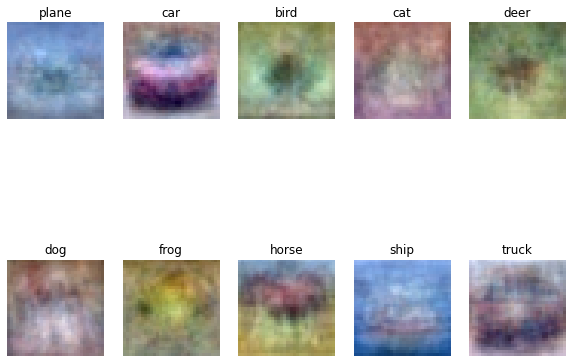

In [38]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])